In [1]:
import numpy as np

from pendulum_MPC_sim import simulate_pendulum_MPC, get_parameter

import matplotlib.pyplot as plt
from objective_function import f_x, get_simoptions_x
from pendulum_model import RAD_TO_DEG
import pickle
import os
from scipy.interpolate import interp1d

import torch
import sys
sys.path.append('..')
from numerical_examples.models import Autoencoder, AutoencoderTrivial

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.xmargin']=0
plt.rcParams['legend.fontsize'] = 11

save_figures = False

In [2]:
def reconstruct_best_cost(J_sample, return_idx=False):
    best_idx = 0
    J_best = [J_sample[0]]  # Initialize with the first cost

    for i, J in enumerate(J_sample[1:], start=1):  # Start indexing from 1
        if J < J_best[-1]:
            best_idx = i  # Update best index
        J_best.append(min(J, J_best[-1]))  # Store the minimum so far

    return (J_best, best_idx) if return_idx else J_best

In [3]:
dict_x0 = {
    'Q_{\Delta u}': 0.1,
    'q_{y_{11}}': 0.1,
    'q_{y_{22}}': 0.9,
    'N_{p}': 40,
    '\epsilon_{c}': 1.0,
    'T_{s}^{MPC}': 25e-3,
    r'\log{\text{QP}_{{\epsilon}_{abs}}}': -3,
    r'\log{\text{QP}_{{\epsilon}_{rel}}}': -2,
    'W_{w_{11}}': 0.1,
    'W_{w_{22}}': 0.4,
    'W_{w_{33}}': 0.1,
    'W_{w_{44}}': 0.4,
    'W_{v_{11}}': 0.5,
    'W_{v_{22}}': 0.5
}

var_names = list(dict_x0.keys())

In [4]:
# load the model
x_bounds = [
    (1e-16, 1),  # 0
    (1e-16, 1),  # 1
    (1e-16, 1),  # 2
    (5, 300),  # 3
    (0.3, 1),  # 4
    (1e-3, 50e-3),  # 5
    (-7, -1),  # 6
    (-7, -1),  # 7
    (1e-16, 1),  # 8
    (1e-16, 1),  # 9
    (1e-16, 1),  # 10
    (1e-16, 1),  # 11
    (1e-16, 1),  # 12
    (1e-16, 1),  # 13
]


# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 14
latent_dim = 3
bounds = (0.0*np.ones(latent_dim), 1.0*np.ones(latent_dim))

model_path = f"../out/mpc/model_{input_dim}d_{latent_dim}l_500iter_exp_decay_alpha_05.pt"
autoencoder = Autoencoder(input_dim=input_dim, latent_dim=latent_dim, out_bounds=x_bounds)

try:
    checkpoint = torch.load(model_path, weights_only=True)
    state_dict = {k.replace('module.', ''): v for k, v in checkpoint['model'].items()}
    autoencoder.load_state_dict(state_dict)
except:
    "Could not load pretrained model"
    try:
        state_dict = torch.load(model_path, weights_only=True)
        autoencoder.load_state_dict(state_dict)
    except:
        "Could not load pretrained model"
autoencoder.to(device)
autoencoder.eval()

# Extract the decoder from the Autoencoder
decoder = autoencoder.decoder


model_path_trivial = f"../out/mpc/model_{input_dim}d_{latent_dim}l_500iter_exp_decay_alpha_05_trivial.pt"
autoencoder_trivial = AutoencoderTrivial(input_dim=input_dim, latent_dim=latent_dim, out_bounds=x_bounds)

try:
    checkpoint = torch.load(model_path_trivial, weights_only=True)
    state_dict = {k.replace('module.', ''): v for k, v in checkpoint['model'].items()}
    autoencoder_trivial.load_state_dict(state_dict)
except:
    "Could not load pretrained model"
    try:
        state_dict = torch.load(model_path_trivial, weights_only=True)
        autoencoder_trivial.load_state_dict(state_dict)
    except:
        "Could not load pretrained model"
autoencoder_trivial.to(device)
autoencoder_trivial.eval()

# Extract the decoder from the Autoencoder
decoder_trivial = autoencoder_trivial.decoder

In [5]:
algo = 'GLIS' # GLIS or BO
machine = 'PC' # PC or PI
eps_calc = 1.0
iter_max_plot = 30

plt.close('all')

X_sample = []
J_sample = []
X_best = []
J_best = []

decoder_Z_sample = []
decoder_X_sample = []
decoder_X_best = []
decoder_J_sample = []
decoder_J_best = []

decoder_trivial_Z_sample = []
decoder_trivial_X_sample = []
decoder_trivial_X_best = []
decoder_trivial_J_sample = []
decoder_trivial_J_best = []


for experiment in range(1200, 1300):
    with open(os.path.join('results/params', f'{experiment:04}.pkl'), 'rb') as f:
        params = pickle.load(f)
    
    res_filename = f"results/experiment_{experiment:04}_res_slower{eps_calc:.0f}_500iter_{algo}_{machine}.pkl"
    results = pickle.load(open(res_filename, "rb"))
    
    decoder_res_filename = f"results/decoder/experiment_{experiment:04}_res_slower{eps_calc:.0f}_50iter_{algo}_{machine}.pkl"
    decoder_results = pickle.load(open(decoder_res_filename, "rb"))
    
    decoder_trivial_res_filename = f"results/decoder/experiment_{experiment:04}_res_slower{eps_calc:.0f}_30iter_{algo}_{machine}_trivial.pkl"
    decoder_results_trivial = pickle.load(open(decoder_trivial_res_filename, "rb"))
    
    # Example usage
    X_sample.append(results['X_sample'][:iter_max_plot])
    # X_best.append(results['x_opt'])
    J = results['J_sample'][:iter_max_plot]  # Your sequence of costs
    J_sample.append(J)
    fopt, idx_opt = reconstruct_best_cost(J[:iter_max_plot], return_idx=True)
    X_best.append(results['X_sample'][idx_opt])
    J_best.append(fopt)
    
    
    # Decoded optimization
    Z_sample = decoder_results['X_sample'][:iter_max_plot]
    Z_opt = decoder_results['x_opt']
    decoder_Z_sample.append(Z_sample)
    with torch.no_grad():
        decoder_X_best.append(decoder(torch.tensor(Z_opt, dtype=torch.float32, device=device)).cpu().numpy())
        decoder_X_sample.append(decoder(torch.tensor(Z_sample, dtype=torch.float32, device=device)).cpu().numpy())
        
    decoder_J = decoder_results['J_sample'][:iter_max_plot]  # Your sequence of costs
    decoder_J_sample.append(decoder_results['J_sample'][:iter_max_plot])
    decoder_J_best.append(reconstruct_best_cost(decoder_J[:iter_max_plot]))
    
    # Decoded trivial optimization
    Z_trivial_sample = decoder_results_trivial['X_sample'][:iter_max_plot]
    Z_trivial_opt = decoder_results_trivial['x_opt']
    decoder_trivial_Z_sample.append(Z_trivial_sample)
    with torch.no_grad():
        decoder_trivial_X_best.append(decoder_trivial(torch.tensor(Z_trivial_opt, dtype=torch.float32, device=device)).cpu().numpy())
        decoder_trivial_X_sample.append(decoder_trivial(torch.tensor(Z_trivial_sample, dtype=torch.float32, device=device)).cpu().numpy())
        
    decoder_trivial_J = decoder_results_trivial['J_sample'][:iter_max_plot]  # Your sequence of costs
    decoder_trivial_J_sample.append(decoder_results_trivial['J_sample'][:iter_max_plot])
    decoder_trivial_J_best.append(reconstruct_best_cost(decoder_trivial_J[:iter_max_plot]))

X_sample = np.stack(X_sample, axis=0)
X_best = np.stack(X_best, axis=0)
J_sample = np.stack(J_sample, axis=0)
J_best = np.stack(J_best, axis=0)

decoder_X_sample = np.stack(decoder_X_sample, axis=0)
decoder_X_best = np.stack(decoder_X_best, axis=0)
decoder_J_sample = np.stack(decoder_J_sample, axis=0)
decoder_J_best = np.stack(decoder_J_best, axis=0)

decoder_trivial_X_sample = np.stack(decoder_trivial_X_sample, axis=0)
decoder_trivial_X_best = np.stack(decoder_trivial_X_best, axis=0)
decoder_trivial_J_sample = np.stack(decoder_trivial_J_sample, axis=0)
decoder_trivial_J_best = np.stack(decoder_trivial_J_best, axis=0)

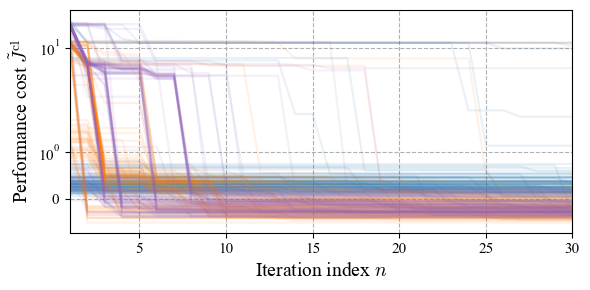

In [6]:
max_evals = decoder_J_best.shape[1]
# Plot the result
fig = plt.figure(figsize=(6, 3))

plt.plot(np.arange(max_evals)+1, J_best[:,:,0].T, label="$x$", color='tab:blue', alpha=.1)

plt.plot(np.arange(max_evals)+1, decoder_J_best[:,:,0].T, label="$z$", color='tab:orange', alpha=.1)

plt.plot(np.arange(max_evals)+1, decoder_trivial_J_best[:,:,0].T, label="$z$", color='tab:purple', alpha=.1)

plt.yscale('symlog')  # Log scale for y-axis
plt.xlim(1, max_evals)
plt.xlabel("Iteration index $n$")
plt.ylabel(r"Performance cost $\tilde{J}^{\mathrm{cl}}$")

# plt.legend(loc='upper right')
plt.tight_layout()

# if save_figures:
#     plt.savefig('fig/mpc/mpc_iter_lines_comparison.pdf')

plt.show()

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


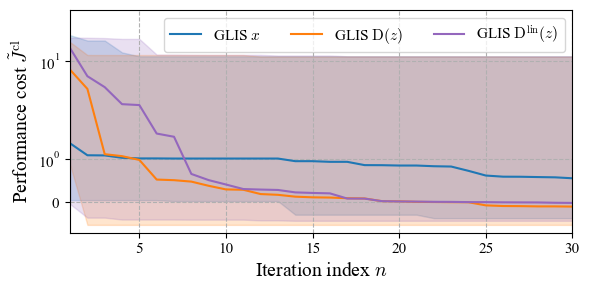

In [7]:
max_evals = J_best.shape[1]

# Compute mean, min, and max instead of std
J_best_mean = np.mean(J_best[:, :max_evals, 0], axis=0)
J_best_min = np.min(J_best[:, :max_evals, 0], axis=0)
J_best_max = np.max(J_best[:, :max_evals, 0], axis=0)

decoder_J_best_mean = np.mean(decoder_J_best[:, :max_evals, 0], axis=0)
decoder_J_best_min = np.min(decoder_J_best[:, :max_evals, 0], axis=0)
decoder_J_best_max = np.max(decoder_J_best[:, :max_evals, 0], axis=0)

decoder_trivial_J_best_mean = np.mean(decoder_trivial_J_best[:, :max_evals, 0], axis=0)
decoder_trivial_J_best_min = np.min(decoder_trivial_J_best[:, :max_evals, 0], axis=0)
decoder_trivial_J_best_max = np.max(decoder_trivial_J_best[:, :max_evals, 0], axis=0)

# Plot the result
fig = plt.figure(figsize=(6, 3))

plt.plot(np.arange(max_evals) + 1, J_best_mean, label="GLIS $x$", color='tab:blue')
plt.fill_between(
    np.arange(max_evals) + 1,
    J_best_min,
    J_best_max,
    color='tab:blue',
    alpha=0.2
)

plt.plot(np.arange(max_evals) + 1, decoder_J_best_mean, label="GLIS $\mathrm{D}(z)$", color='tab:orange')
plt.fill_between(
    np.arange(max_evals) + 1,
    decoder_J_best_min,
    decoder_J_best_max,
    color='tab:orange',
    alpha=0.2
)

plt.plot(np.arange(max_evals) + 1, decoder_trivial_J_best_mean, label="GLIS $\mathrm{D}^{\mathrm{lin}}(z)$", color='tab:purple')
plt.fill_between(
    np.arange(max_evals) + 1,
    decoder_trivial_J_best_min,
    decoder_trivial_J_best_max,
    color='tab:purple',
    alpha=0.2
)

plt.yscale('symlog')  # Log scale for y-axis
plt.xlim(1, max_evals)
plt.ylim(-0.7, 45)
plt.xlabel("Iteration index $n$")
plt.ylabel(r"Performance cost $\tilde{J}^{\mathrm{cl}}$")

plt.legend(loc='upper right', ncols=3, fontsize=11)
plt.tight_layout()

# if save_figures:
#     plt.savefig('fig/mpc/mpc_iter_lines_comparison.pdf')
plt.savefig('fig/mpc/mpc_iter_lines_comparison.pdf', dpi=300)

plt.show()


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


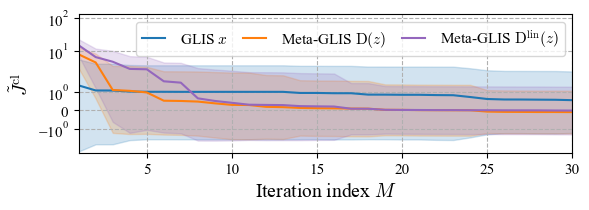

In [8]:
max_evals = J_best.shape[1]
J_best_mean = np.mean(J_best[:,:max_evals,0], axis=0)
J_best_std = np.std(J_best[:,:max_evals,0], axis=0)
decoder_J_best_mean = np.mean(decoder_J_best[:,:max_evals,0], axis=0)
decoder_J_best_std = np.std(decoder_J_best[:,:max_evals,0], axis=0)
decoder_trivial_J_best_mean = np.mean(decoder_trivial_J_best[:,:max_evals,0], axis=0)
decoder_trivial_J_best_std = np.std(decoder_trivial_J_best[:,:max_evals,0], axis=0)

# Plot the result
fig = plt.figure(figsize=(6, 2.2))

plt.plot(np.arange(max_evals)+1, J_best_mean, label="GLIS $x$", color='tab:blue')
plt.fill_between(
    np.arange(max_evals)+1,
    J_best_mean - J_best_std,
    J_best_mean + J_best_std,
    color='tab:blue',
    alpha=0.2,
    label='',
    rasterized=True
)

plt.plot(np.arange(max_evals)+1, decoder_J_best_mean, label="Meta-GLIS $\mathrm{D}(z)$", color='tab:orange')
plt.fill_between(
    np.arange(max_evals)+1,
    decoder_J_best_mean - decoder_J_best_std,
    decoder_J_best_mean + decoder_J_best_std,
    color='tab:orange',
    alpha=0.2,
    label='',
    rasterized=True
)

plt.plot(np.arange(max_evals)+1, decoder_trivial_J_best_mean, label="Meta-GLIS $\mathrm{D}^{\mathrm{lin}}(z)$", color='tab:purple')
plt.fill_between(
    np.arange(max_evals)+1,
    decoder_trivial_J_best_mean - decoder_trivial_J_best_std,
    decoder_trivial_J_best_mean + decoder_trivial_J_best_std,
    color='tab:purple',
    alpha=0.2,
    label=''
)

plt.yscale('symlog')  # Log scale for y-axis
plt.xlim(1, max_evals)
plt.ylim(-3, 130)
plt.xlabel("Iteration index $M$")
plt.ylabel(r"$\tilde{J}^{\mathrm{cl}}$")

plt.legend(loc='upper right', ncols=3, handlelength=1.5, labelspacing=0.5, handletextpad=1, columnspacing=1)
plt.tight_layout()

plt.savefig('fig/mpc/mpc_iter_lines_comparison_mean_std_v2.pdf')

plt.show()

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


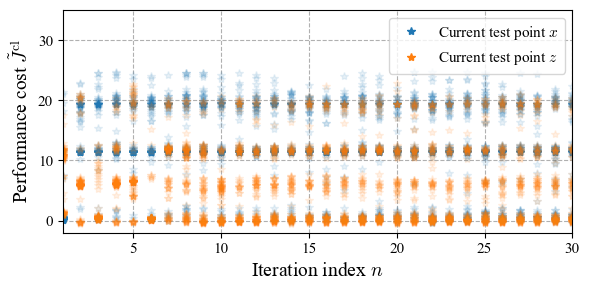

In [9]:
# Plot the result
fig = plt.figure(figsize=(6, 3))

plt.plot([], [], marker='*', linestyle='', label='Current test point $x$', color='tab:blue', alpha=1)
plt.plot([], [], marker='*', linestyle='', label='Current test point $z$', color='tab:orange', alpha=1)

plt.plot(np.arange(max_evals)+1, J_sample[:,:max_evals,0].T, marker='*', linestyle='', label='', color='tab:blue', alpha=0.1, rasterized=True)
plt.plot(np.arange(max_evals)+1, decoder_J_sample[:,:max_evals,0].T, marker='*', linestyle='', label='', color='tab:orange', alpha=0.1, rasterized=True)

# plt.yscale('symlog')  # Log scale for y-axis
plt.xlabel("Iteration index $n$")
plt.ylabel(r"Performance cost $\tilde{J}^{\mathrm{cl}}$")

plt.xlim(1, max_evals)
plt.ylim(-2, 35)

plt.legend(loc='upper right')
plt.tight_layout()

plt.savefig('fig/mpc/mpc_iter_scatter_comparison.pdf', dpi=300)

plt.show()

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


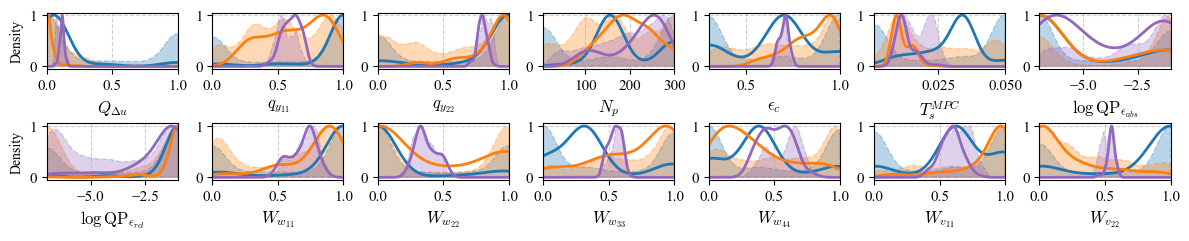

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from scipy.stats import gaussian_kde

# Colormap for consistent colors
cmap = plt.get_cmap("tab10")

# Create subplots: 2 rows, 7 columns
fig, axes = plt.subplots(2, 7, figsize=(12, 2.5))
axes = axes.flatten()

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Use scientific notation outside [10^-2, 10^2]
formatter.set_useOffset(False)

# Plot KDEs
for idx, ax in enumerate(axes[:X_sample.shape[-1]]):
    # Compute the KDE
    data = X_sample[:, :, idx].flatten()
    kde = gaussian_kde(data, bw_method='silverman')  # You can adjust bandwidth here
    x_vals = np.linspace(np.min(data), np.max(data), 1000)  # Generate points for x-axis
    y_vals = kde(x_vals)  # Evaluate KDE at the points
    y_vals /= np.max(y_vals)  # Normalize to [0, 1]
    # ax.plot(x_vals, y_vals, color='tab:blue', alpha=0.7, lw=2)
    ax.fill_between(x_vals, y_vals, color='tab:blue', alpha=0.3, linestyle='--')
    
    # Compute the KDE
    data = decoder_X_sample[:, :, idx].flatten()
    kde = gaussian_kde(data, bw_method='silverman')  # You can adjust bandwidth here
    # x_vals = np.linspace(np.min(data), np.max(data), 1000)  # Generate points for x-axis
    y_vals = kde(x_vals)  # Evaluate KDE at the points
    y_vals /= np.max(y_vals)  # Normalize to [0, 1]
    # ax.plot(x_vals, y_vals, color='tab:orange', alpha=0.7, lw=2)
    ax.fill_between(x_vals, y_vals, color='tab:orange', alpha=0.3, linestyle='--')
    
    # Compute the KDE
    data = decoder_trivial_X_sample[:, :, idx].flatten()
    kde = gaussian_kde(data, bw_method='silverman')  # You can adjust bandwidth here
    # x_vals = np.linspace(np.min(data), np.max(data), 1000)  # Generate points for x-axis
    y_vals = kde(x_vals)  # Evaluate KDE at the points
    y_vals /= np.max(y_vals)  # Normalize to [0, 1]
    # ax.plot(x_vals, y_vals, color='tab:orange', alpha=0.7, lw=2)
    ax.fill_between(x_vals, y_vals, color='tab:purple', alpha=0.3, linestyle='--')
    
    # Compute the KDE
    data = X_best[:, idx].flatten()
    kde = gaussian_kde(data, bw_method='silverman')  # You can adjust bandwidth here
    # x_vals = np.linspace(np.min(data), np.max(data), 1000)  # Generate points for x-axis
    y_vals = kde(x_vals)  # Evaluate KDE at the points
    y_vals /= np.max(y_vals)  # Normalize to [0, 1]
    # Plot the KDE
    ax.plot(x_vals, y_vals, color='tab:blue', alpha=1, lw=2)
    # ax.fill_between(x_vals, y_vals, color='tab:blue', alpha=0.3)
    
    # Compute the KDE
    data = decoder_X_best[:, idx].flatten()
    kde = gaussian_kde(data, bw_method='silverman')  # You can adjust bandwidth here
    # x_vals = np.linspace(np.min(data), np.max(data), 1000)  # Generate points for x-axis
    y_vals = kde(x_vals)  # Evaluate KDE at the points
    y_vals /= np.max(y_vals)  # Normalize to [0, 1]
    # Plot the KDE
    ax.plot(x_vals, y_vals, color='tab:orange', alpha=1, lw=2)
    # ax.fill_between(x_vals, y_vals, color='tab:blue', alpha=0.3)
    
    # Compute the KDE
    data = decoder_trivial_X_best[:, idx].flatten()
    kde = gaussian_kde(data, bw_method='silverman')  # You can adjust bandwidth here
    # x_vals = np.linspace(np.min(data), np.max(data), 1000)  # Generate points for x-axis
    y_vals = kde(x_vals)  # Evaluate KDE at the points
    y_vals /= np.max(y_vals)  # Normalize to [0, 1]
    # Plot the KDE
    ax.plot(x_vals, y_vals, color='tab:purple', alpha=1, lw=2)
    # ax.fill_between(x_vals, y_vals, color='tab:blue', alpha=0.3)
    
    
    ax.set_xlabel(f"${var_names[idx]}$", fontsize=12)

    # Set y-label only for the leftmost column (idx % 7 == 0)
    if idx % 7 == 0:
        ax.set_ylabel("Density", fontsize=10)
                      
    # ax.yaxis.set_major_formatter(formatter)
    # ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))  # Format with 2 decimal places
    ax.grid(True, linestyle='--', alpha=0.6)

# Turn off unused axes
for ax in axes[X_sample.shape[-1]:]:
    ax.axis('off')

fig.align_ylabels(axes)

# Adjust layout and add a title
# fig.subplots_adjust(wspace=0.1, hspace=0.3)  # Reduce horizontal and vertical space
# plt.suptitle("Variable Distributions (KDE)", fontsize=16, y=1.05)
plt.tight_layout(h_pad=0, w_pad=0)

plt.savefig('fig/mpc/mpc_distribution_comparison.pdf', dpi=300)

plt.show()

In [11]:
# Initialize lists to store simulation outputs
t_list = []
x_list = []
u_list = []
y_list = []
y_meas_list = []
x_ref_list = []
x_MPC_pred_list = []
x_fast_list = []
x_ref_fast_list = []
y_ref_list = []
uref_list = []
u_fast_list = []
t_int_list = []
t_fast_list = []
t_calc_list = []

failed_experiments = []

# Simulation loop
experiment = 1200
patience = 5

if os.path.exists('results/final_sim/sim_results.pkl'):
    with open('results/final_sim/sim_results.pkl', 'rb') as f:
        results = pickle.load(f)
    u_fast_list = results['u_fast_list']
    x_fast_list = results['x_fast_list']
    x_ref_fast_list = results['x_ref_fast_list']
else:
    while experiment < 1300:
        print('Simulating experiment:', experiment)
        
        # Load the params to simulate
        with open(os.path.join('results/params', f'{experiment:04}.pkl'), 'rb') as f:
            params = pickle.load(f)

        # Re-simulate with the optimal point
        x_opt = X_best[experiment-1200]
        simopt = get_simoptions_x(x_opt)
    
        t_ref_vec = np.array([0.0, 5.0, 10.0, 13.0, 20.0, 22.0, 25.0, 30.0, 35.0, 40.0, 100.0])
        p_ref_vec = np.array([0.0, 0.4, 0.0, 0.9, 0.9, 0.4, 0.4, 0.4, 0.0, 0.0, 0.0])
        rp_fun = interp1d(t_ref_vec, p_ref_vec, kind='linear')
    
        def xref_fun_def(t):
            return np.array([rp_fun(t), 0.0, 0.0, 0.0])
    
        simopt['xref_fun'] = xref_fun_def
        simout = simulate_pendulum_MPC(simopt, params)
    
        # Extract values
        t, x, u, y = simout['t'], simout['x'], simout['u'], simout['y']
        y_meas, x_ref = simout['y_meas'], simout['x_ref']
        x_MPC_pred, x_fast, x_ref_fast = simout['x_MPC_pred'], simout['x_fast'], simout['x_ref_fast']
        y_ref = x_ref[:, [0, 2]]
        uref = get_parameter({}, 'uref')
        u_fast = simout['u_fast']
        t_int, t_fast, t_calc = simout['t_int_fast'], simout['t_fast'], simout['t_calc']
    
        # Check emergency fast
        if np.any(simout['emergency_fast'] == 1):
            print("Emergency triggered at least once.")
            
            # Redo the experiment
            if patience > 0: # Retry
                print('Re-trying..')
                patience -= 1
                continue
            else: # Continue and discard
                print('Failed. Skipping.')
                experiment += 1
                patience = 5
                continue
        else:
            print("No emergency triggered.")
            print("------------------------")
            experiment += 1
            
        # Store in lists
        t_list.append(t)
        x_list.append(x)
        u_list.append(u)
        y_list.append(y)
        y_meas_list.append(y_meas)
        x_ref_list.append(x_ref)
        x_MPC_pred_list.append(x_MPC_pred)
        x_fast_list.append(x_fast)
        x_ref_fast_list.append(x_ref_fast)
        y_ref_list.append(y_ref)
        uref_list.append(uref)
        u_fast_list.append(u_fast)
        t_int_list.append(t_int)
        t_fast_list.append(t_fast)
        t_calc_list.append(t_calc)
        
    u_fast_list = np.stack(u_fast_list, axis=0)
    x_fast_list = np.stack(x_fast_list, axis=0)
    x_ref_fast_list = np.stack(x_ref_fast_list, axis=0)
    
    # Save variables to a single file
    # with open('results/final_sim/sim_results.pkl', 'wb') as f:
    #     pickle.dump({
    #         'u_fast_list': u_fast_list,
    #         'x_fast_list': x_fast_list,
    #         'x_ref_fast_list': x_ref_fast_list
    #     }, f)

In [12]:
# Simulation loop

# Initialize lists to store simulation outputs
decoder_t_list = []
decoder_x_list = []
decoder_u_list = []
decoder_y_list = []
decoder_y_meas_list = []
decoder_x_ref_list = []
decoder_x_MPC_pred_list = []
decoder_x_fast_list = []
decoder_x_ref_fast_list = []
decoder_y_ref_list = []
decoder_uref_list = []
decoder_u_fast_list = []
decoder_t_int_list = []
decoder_t_fast_list = []
decoder_t_calc_list = []

experiment = 1200
patience = 5

if os.path.exists('results/final_sim/decoder_sim_results.pkl'):
    with open('results/final_sim/decoder_sim_results.pkl', 'rb') as f:
        results = pickle.load(f)
    decoder_u_fast_list = results['decoder_u_fast_list']
    decoder_x_fast_list = results['decoder_x_fast_list']
    decoder_x_ref_fast_list = results['decoder_x_ref_fast_list']
else:
    while experiment < 1300:
        print('Simulating experiment:', experiment)
        with open(os.path.join('results/params', f'{experiment:04}.pkl'), 'rb') as f:
            params = pickle.load(f)
        
        decoder_res_filename = f"results/decoder/experiment_{experiment:04}_res_slower{eps_calc:.0f}_50iter_{algo}_{machine}.pkl"
        decoder_results = pickle.load(open(decoder_res_filename, "rb"))
        
        # Re-simulate with the optimal point
        z_opt = decoder_results['x_opt']
        with torch.no_grad():
            x_opt = decoder(torch.tensor(z_opt, dtype=torch.float32, device=device)).cpu().numpy()
        simopt = get_simoptions_x(x_opt)
    
        t_ref_vec = np.array([0.0, 5.0, 10.0, 13.0, 20.0, 22.0, 25.0, 30.0, 35.0, 40.0, 100.0])
        p_ref_vec = np.array([0.0, 0.4, 0.0, 0.9, 0.9, 0.4, 0.4, 0.4, 0.0, 0.0, 0.0])
        rp_fun = interp1d(t_ref_vec, p_ref_vec, kind='linear')
    
        def xref_fun_def(t):
            return np.array([rp_fun(t), 0.0, 0.0, 0.0])
    
        simopt['xref_fun'] = xref_fun_def
        simout = simulate_pendulum_MPC(simopt, params)
    
        # Extract values
        t, x, u, y = simout['t'], simout['x'], simout['u'], simout['y']
        y_meas, x_ref = simout['y_meas'], simout['x_ref']
        x_MPC_pred, x_fast, x_ref_fast = simout['x_MPC_pred'], simout['x_fast'], simout['x_ref_fast']
        y_ref = x_ref[:, [0, 2]]
        uref = get_parameter({}, 'uref')
        u_fast = simout['u_fast']
        t_int, t_fast, t_calc = simout['t_int_fast'], simout['t_fast'], simout['t_calc']
    
        # Check emergency fast
        if np.any(simout['emergency_fast'] == 1):
            print("Emergency triggered at least once.")
            
            # Redo the experiment
            if patience > 0: # Retry
                print('Re-trying..')
                patience -= 1
                continue
            else: # Continue and discard
                print('Failed. Skipping.')
                experiment += 1
                patience = 5
                continue
        else:
            print("No emergency triggered.")
            print("------------------------")
            experiment += 1
            
        # Store in lists
        decoder_t_list.append(t)
        decoder_x_list.append(x)
        decoder_u_list.append(u)
        decoder_y_list.append(y)
        decoder_y_meas_list.append(y_meas)
        decoder_x_ref_list.append(x_ref)
        decoder_x_MPC_pred_list.append(x_MPC_pred)
        decoder_x_fast_list.append(x_fast)
        decoder_x_ref_fast_list.append(x_ref_fast)
        decoder_y_ref_list.append(y_ref)
        decoder_uref_list.append(uref)
        decoder_u_fast_list.append(u_fast)
        decoder_t_int_list.append(t_int)
        decoder_t_fast_list.append(t_fast)
        decoder_t_calc_list.append(t_calc)
    
    # To Numpy
    decoder_u_fast_list = np.stack(decoder_u_fast_list, axis=0)
    decoder_x_fast_list = np.stack(decoder_x_fast_list, axis=0)
    decoder_x_ref_fast_list = np.stack(decoder_x_ref_fast_list, axis=0)
    
    # Save variables to a single file
    # with open('results/final_sim/decoder_sim_results.pkl', 'wb') as f:
    #     pickle.dump({
    #         'decoder_u_fast_list': decoder_u_fast_list,
    #         'decoder_x_fast_list': decoder_x_fast_list,
    #         'decoder_x_ref_fast_list': decoder_x_ref_fast_list
    #     }, f)

In [13]:
# Simulation loop

# Initialize lists to store simulation outputs
decoder_trivial_t_list = []
decoder_trivial_x_list = []
decoder_trivial_u_list = []
decoder_trivial_y_list = []
decoder_trivial_y_meas_list = []
decoder_trivial_x_ref_list = []
decoder_trivial_x_MPC_pred_list = []
decoder_trivial_x_fast_list = []
decoder_trivial_x_ref_fast_list = []
decoder_trivial_y_ref_list = []
decoder_trivial_uref_list = []
decoder_trivial_u_fast_list = []
decoder_trivial_t_int_list = []
decoder_trivial_t_fast_list = []
decoder_trivial_t_calc_list = []

experiment = 1200
patience = 5

if os.path.exists('results/final_sim/decoder_trivial_sim_results.pkl'):
    with open('results/final_sim/decoder_trivial_sim_results.pkl', 'rb') as f:
        results = pickle.load(f)
    decoder_trivial_u_fast_list = results['decoder_trivial_u_fast_list']
    decoder_trivial_x_fast_list = results['decoder_trivial_x_fast_list']
    decoder_trivial_x_ref_fast_list = results['decoder_trivial_x_ref_fast_list']
else:
    while experiment < 1300:
        print('Simulating experiment:', experiment)
        with open(os.path.join('results/params', f'{experiment:04}.pkl'), 'rb') as f:
            params = pickle.load(f)
        
        decoder_trivial_res_filename = f"results/decoder/experiment_{experiment:04}_res_slower{eps_calc:.0f}_30iter_{algo}_{machine}_trivial.pkl"
        decoder_trivial_results = pickle.load(open(decoder_trivial_res_filename, "rb"))
        
        # Re-simulate with the optimal point
        z_opt = decoder_trivial_results['x_opt']
        with torch.no_grad():
            x_opt = decoder_trivial(torch.tensor(z_opt, dtype=torch.float32, device=device)).cpu().numpy()
        simopt = get_simoptions_x(x_opt)
    
        t_ref_vec = np.array([0.0, 5.0, 10.0, 13.0, 20.0, 22.0, 25.0, 30.0, 35.0, 40.0, 100.0])
        p_ref_vec = np.array([0.0, 0.4, 0.0, 0.9, 0.9, 0.4, 0.4, 0.4, 0.0, 0.0, 0.0])
        rp_fun = interp1d(t_ref_vec, p_ref_vec, kind='linear')
    
        def xref_fun_def(t):
            return np.array([rp_fun(t), 0.0, 0.0, 0.0])
    
        simopt['xref_fun'] = xref_fun_def
        simout = simulate_pendulum_MPC(simopt, params)
    
        # Extract values
        t, x, u, y = simout['t'], simout['x'], simout['u'], simout['y']
        y_meas, x_ref = simout['y_meas'], simout['x_ref']
        x_MPC_pred, x_fast, x_ref_fast = simout['x_MPC_pred'], simout['x_fast'], simout['x_ref_fast']
        y_ref = x_ref[:, [0, 2]]
        uref = get_parameter({}, 'uref')
        u_fast = simout['u_fast']
        t_int, t_fast, t_calc = simout['t_int_fast'], simout['t_fast'], simout['t_calc']
    
        # Check emergency fast
        if np.any(simout['emergency_fast'] == 1):
            print("Emergency triggered at least once.")
            
            # Redo the experiment
            if patience > 0: # Retry
                print('Re-trying..')
                patience -= 1
                continue
            else: # Continue and discard
                print('Failed. Skipping.')
                experiment += 1
                patience = 5
                continue
        else:
            print("No emergency triggered.")
            print("------------------------")
            experiment += 1
            
        # Store in lists
        decoder_trivial_t_list.append(t)
        decoder_trivial_x_list.append(x)
        decoder_trivial_u_list.append(u)
        decoder_trivial_y_list.append(y)
        decoder_trivial_y_meas_list.append(y_meas)
        decoder_trivial_x_ref_list.append(x_ref)
        decoder_trivial_x_MPC_pred_list.append(x_MPC_pred)
        decoder_trivial_x_fast_list.append(x_fast)
        decoder_trivial_x_ref_fast_list.append(x_ref_fast)
        decoder_trivial_y_ref_list.append(y_ref)
        decoder_trivial_uref_list.append(uref)
        decoder_trivial_u_fast_list.append(u_fast)
        decoder_trivial_t_int_list.append(t_int)
        decoder_trivial_t_fast_list.append(t_fast)
        decoder_trivial_t_calc_list.append(t_calc)
    
    # To Numpy
    decoder_trivial_u_fast_list = np.stack(decoder_trivial_u_fast_list, axis=0)
    decoder_trivial_x_fast_list = np.stack(decoder_trivial_x_fast_list, axis=0)
    decoder_trivial_x_ref_fast_list = np.stack(decoder_trivial_x_ref_fast_list, axis=0)
    
    # Save variables to a single file
    # with open('results/final_sim/decoder_trivial_sim_results.pkl', 'wb') as f:
    #     pickle.dump({
    #         'decoder_trivial_u_fast_list': decoder_trivial_u_fast_list,
    #         'decoder_trivial_x_fast_list': decoder_trivial_x_fast_list,
    #         'decoder_trivial_x_ref_fast_list': decoder_trivial_x_ref_fast_list
    #     }, f)

In [14]:
# Save variables to a single file
# with open('results/final_sim/decoder_trivial_sim_results.pkl', 'wb') as f:
#     pickle.dump({
#         'decoder_trivial_u_fast_list': decoder_trivial_u_fast_list,
#         'decoder_trivial_x_fast_list': decoder_trivial_x_fast_list,
#         'decoder_trivial_x_ref_fast_list': decoder_trivial_x_ref_fast_list
#     }, f)

In [15]:
dt = 1e-3
t_fast = np.arange(0, 40-dt, dt)
u_fast_list = np.stack(u_fast_list, axis=0)
x_fast_list = np.stack(x_fast_list, axis=0)
x_ref_fast_list = np.stack(x_ref_fast_list, axis=0)

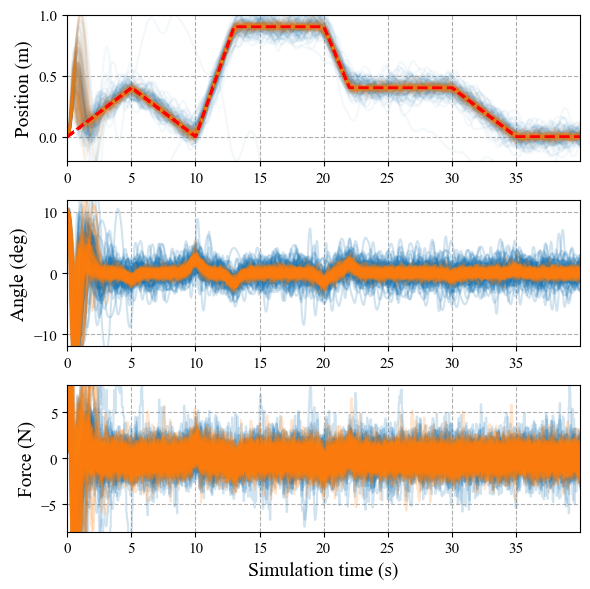

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(6, 6))
axes[0].plot(t_fast, x_fast_list[:,:,0].T, "tab:blue", label='$p$', alpha=0.05)
axes[0].plot(t_fast, decoder_x_fast_list[:,:,0].T, "tab:orange", label='$p$', alpha=0.05)
axes[0].plot(t_fast, x_ref_fast_list[0,:,0].T, "r--", label="$p^{\mathrm{ref}}$", linewidth=2)
axes[0].set_ylim(-0.2, 1.0)
axes[0].set_ylabel("Position (m)")

axes[1].plot(t_fast, x_fast_list[:,:,2].T * RAD_TO_DEG, 'tab:blue', label="$\phi$", alpha=0.2)
axes[1].plot(t_fast, decoder_x_fast_list[:,:,2].T * RAD_TO_DEG, 'tab:orange', label="$\phi$", alpha=0.2)
idx_pred = 0
axes[1].set_ylim(-12, 12)
axes[1].set_ylabel("Angle (deg)")

axes[2].plot(t_fast, u_fast_list[:,:,0].T, 'tab:blue', label="$u$", alpha=0.2)
axes[2].plot(t_fast, decoder_u_fast_list[:,:,0].T, 'tab:orange', label="$u$", alpha=0.2)
axes[2].set_ylim(-8, 8)
axes[2].set_ylabel("Force (N)")
axes[2].set_xlabel("Simulation time (s)")

for ax in axes:
    ax.grid(True)
    # ax.legend(loc='upper right')

# fig.savefig(fig_path, bbox_inches='tight')
plt.tight_layout()

plt.show()

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


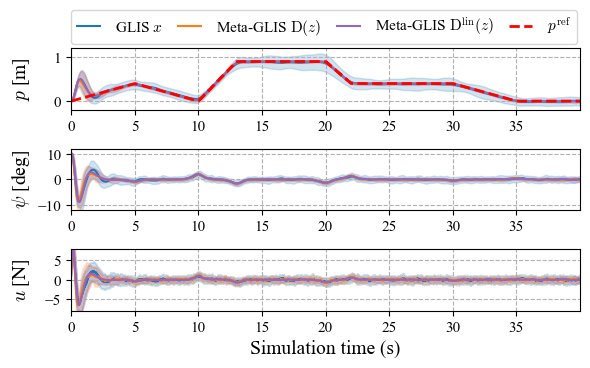

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(6, 4))

# Compute statistics
mean_x = np.mean(x_fast_list, axis=0)
std_x = np.std(x_fast_list, axis=0)

mean_decoder_x = np.mean(decoder_x_fast_list, axis=0)
std_decoder_x = np.std(decoder_x_fast_list, axis=0)

mean_decoder_trivial_x = np.mean(decoder_trivial_x_fast_list, axis=0)
std_decoder_trivial_x = np.std(decoder_trivial_x_fast_list, axis=0)

mean_u = np.mean(u_fast_list, axis=0)
std_u = np.std(u_fast_list, axis=0)

mean_decoder_u = np.mean(decoder_u_fast_list, axis=0)
std_decoder_u = np.std(decoder_u_fast_list, axis=0)

mean_decoder_trivial_u = np.mean(decoder_trivial_u_fast_list, axis=0)
std_decoder_trivial_u = np.std(decoder_trivial_u_fast_list, axis=0)

# Position
axes[0].plot(t_fast.flatten(), mean_x[:, 0], "tab:blue", label="GLIS $x$")
axes[0].fill_between(t_fast.flatten(), mean_x[:, 0] - std_x[:, 0], mean_x[:, 0] + std_x[:, 0], color="tab:blue", alpha=0.2)
axes[0].plot(t_fast.flatten(), mean_decoder_x[:, 0], "tab:orange", label="Meta-GLIS $\mathrm{D}(z)$")
axes[0].plot(t_fast.flatten(), mean_decoder_trivial_x[:, 0], "tab:purple", label="Meta-GLIS $\mathrm{D}^{\mathrm{lin}}(z)$")
axes[0].fill_between(t_fast.flatten(), mean_decoder_x[:, 0] - std_decoder_x[:, 0], mean_decoder_x[:, 0] + std_decoder_x[:, 0], color="tab:orange", alpha=0.2, rasterized=True)
axes[0].fill_between(t_fast.flatten(), mean_decoder_trivial_x[:, 0] - std_decoder_trivial_x[:, 0], mean_decoder_trivial_x[:, 0] + std_decoder_trivial_x[:, 0], color="tab:purple", alpha=0.2, rasterized=True)
axes[0].plot(t_fast.flatten(), np.mean(x_ref_fast_list, axis=0)[:, 0], "r--", label="$p^{\mathrm{ref}}$", linewidth=2)
axes[0].legend(loc="upper right", ncols=4, handlelength=1.5, labelspacing=0.5, handletextpad=1, columnspacing=1, bbox_to_anchor=(1.01, 1.75))
axes[0].set_ylim(-0.2, 1.2)
axes[0].set_ylabel("$p$ [m]")

# Angle
axes[1].plot(t_fast.flatten(), mean_x[:, 2] * RAD_TO_DEG, 'tab:blue', label="$\psi$ (GLIS $x$)")
axes[1].fill_between(t_fast.flatten(), (mean_x[:, 2] - std_x[:, 2]) * RAD_TO_DEG, (mean_x[:, 2] + std_x[:, 2]) * RAD_TO_DEG, color="tab:blue", alpha=0.2, rasterized=True)
axes[1].plot(t_fast.flatten(), mean_decoder_x[:, 2] * RAD_TO_DEG, 'tab:orange', label="$\psi$ (GLIS $\mathrm{D}(z)$)")
axes[1].fill_between(t_fast.flatten(), (mean_decoder_x[:, 2] - std_decoder_x[:, 2]) * RAD_TO_DEG, (mean_decoder_x[:, 2] + std_decoder_x[:, 2]) * RAD_TO_DEG, color="tab:orange", alpha=0.2, rasterized=True)
axes[1].plot(t_fast.flatten(), mean_decoder_trivial_x[:, 2] * RAD_TO_DEG, 'tab:purple', label="$\psi$ (GLIS $\mathrm{D}^{\mathrm{lin}}(z)$)")
axes[1].fill_between(t_fast.flatten(), (mean_decoder_trivial_x[:, 2] - std_decoder_trivial_x[:, 2]) * RAD_TO_DEG, (mean_decoder_trivial_x[:, 2] + std_decoder_trivial_x[:, 2]) * RAD_TO_DEG, color="tab:purple", alpha=0.2, rasterized=True)
# axes[1].legend(loc="upper right", ncols=3, handlelength=1.5)
axes[1].set_ylim(-12, 12)
axes[1].set_ylabel("$\psi$ [deg]")

# Control input (Force)
axes[2].plot(t_fast.flatten(), mean_u[:, 0], 'tab:blue', label="$u$ (GLIS $x$)")
axes[2].fill_between(t_fast.flatten(), mean_u[:, 0] - std_u[:, 0], mean_u[:, 0] + std_u[:, 0], color="tab:blue", alpha=0.2, rasterized=True)
axes[2].plot(t_fast.flatten(), mean_decoder_u[:, 0], 'tab:orange', label="$u$ (GLIS $\mathrm{D}(z)$)")
axes[2].fill_between(t_fast.flatten(), mean_decoder_u[:, 0] - std_decoder_u[:, 0], mean_decoder_u[:, 0] + std_decoder_u[:, 0], color="tab:orange", alpha=0.2, rasterized=True)
axes[2].plot(t_fast.flatten(), mean_decoder_trivial_u[:, 0], 'tab:purple', label="$u$ (GLIS $\mathrm{D}^{\mathrm{lin}}(z)$)")
axes[2].fill_between(t_fast.flatten(), mean_decoder_trivial_u[:, 0] - std_decoder_trivial_u[:, 0], mean_decoder_trivial_u[:, 0] + std_decoder_trivial_u[:, 0], color="tab:purple", alpha=0.2, rasterized=True)
# axes[2].legend(loc="upper right", ncols=3, handlelength=1.5)
axes[2].set_ylim(-8, 8)
axes[2].set_ylabel("$u$ [N]")
axes[2].set_xlabel("Simulation time (s)")

# Formatting
for ax in axes:
    ax.grid(True)

fig.align_ylabels()

plt.tight_layout()
plt.savefig('fig/mpc/mpc_simulation_v2.pdf', dpi=200)
plt.show()

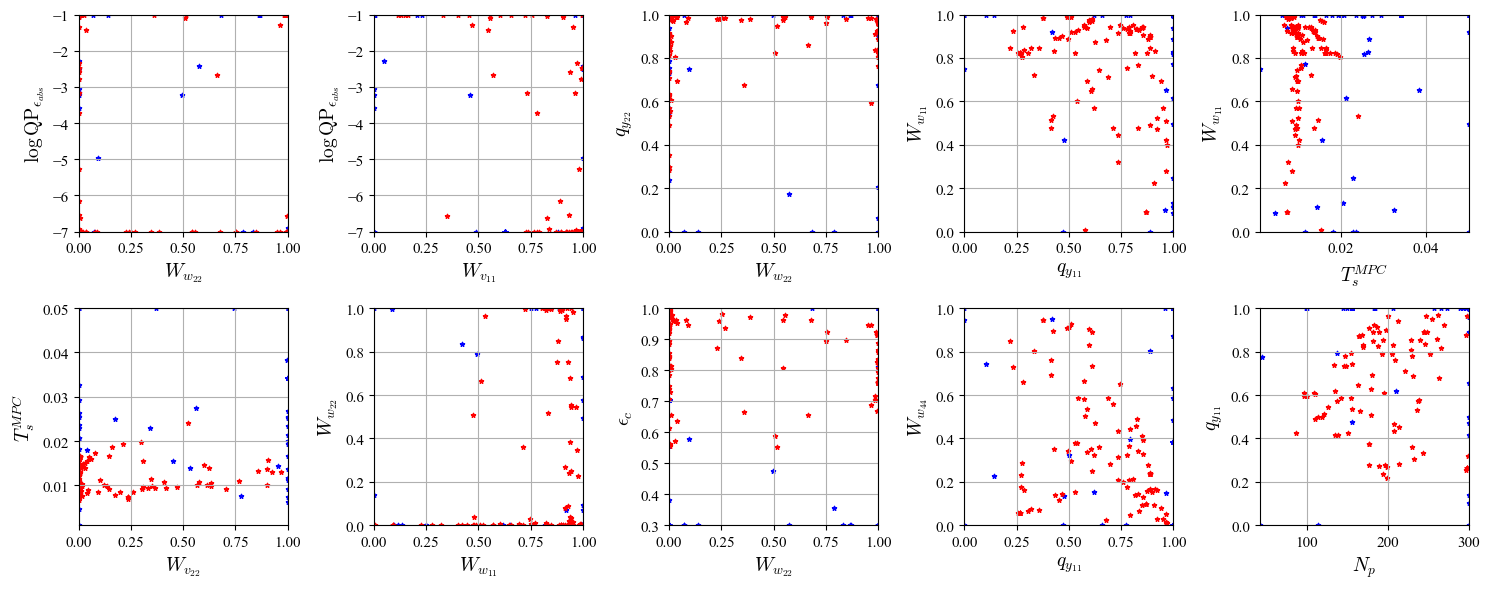

In [78]:
dim_pairs = [(9, 6),
             (12, 6),
             (9, 2),
             (1, 8),
             (5, 8),
             (13, 5),
             (8, 9),
             (9, 4),
             (1, 11),
             (3, 1)]

# Define subplot grid (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()  # Flatten for easier iteration

# Loop through each selected pair and plot
for ax, (first_idx, second_idx) in zip(axes, dim_pairs):
    # ax.scatter(
    #     X_sample[:, :, first_idx], X_sample[:, :, second_idx],
    #     s=5, alpha=0.5, color='tab:blue'
    # )
    ax.scatter(
        X_best[:, first_idx], X_best[:, second_idx],
        s=10, alpha=1, color='blue', marker='*'
    )
    # ax.scatter(
    #     decoder_X_sample[:, :, first_idx], decoder_X_sample[:, :, second_idx],
    #     s=5, alpha=0.5, color='tab:orange'
    # )
    ax.scatter(
        decoder_X_best[:, first_idx], decoder_X_best[:, second_idx],
        s=10, alpha=1, color='red', marker='*'
    )
    ax.set_xlabel(f'${var_names[first_idx]}$')
    ax.set_ylabel(f'${var_names[second_idx]}$')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
X_best.plot

In [76]:
decoder_X_best.shape

(100, 14)

In [72]:
X_sample.shape

(100, 30, 14)

/tmp/ipykernel_271282/1141129927.py:22: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


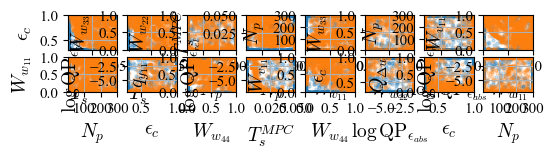

In [57]:
# Randomly select 10 unique pairs of dimensions
dim_pairs = [tuple(np.random.choice(X_sample.shape[-1], size=2, replace=False)) for _ in range(16)]

# Define subplot grid (2 rows, 5 columns)
fig, axes = plt.subplots(2, 8, figsize=(6, 1))
axes = axes.flatten()  # Flatten for easier iteration

# Loop through each selected pair and plot
for ax, (first_idx, second_idx) in zip(axes, dim_pairs):
    ax.scatter(
        X_sample[:, :, first_idx], X_sample[:, :, second_idx], 
        s=5, alpha=0.2, color='tab:blue'
    )
    ax.scatter(
        decoder_X_sample[:, :, first_idx], decoder_X_sample[:, :, second_idx], 
        s=5, alpha=0.2, color='tab:orange'
    )
    ax.set_xlabel(f'${var_names[first_idx]}$')
    ax.set_ylabel(f'${var_names[second_idx]}$')
    
# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
print(decoder_results['J_opt'])
print(results['J_opt'])

print(decoder_results['time_iter'].mean())
print(results['time_iter'].mean())

print(decoder_results['time_opt_acquisition'].mean())
print(results['time_opt_acquisition'].mean())

print(decoder_results['time_fit_surrogate'].mean())
print(results['time_fit_surrogate'].mean())

In [ ]:
decoder_results['out'].keys()

In [ ]:
decoder_results['out']['W']

In [ ]:
print(decoder_results['J_opt'])
print(decoder_results['out']['fopt'])

In [ ]:
plt.plot(decoder_results['J_sample'])

In [ ]:



    # In[]
    FIG_FOLDER = 'fig'
    if not os.path.isdir(FIG_FOLDER):
        os.makedirs(FIG_FOLDER)

    # In[Iteration plot]

    J = results['J_sample']
    J_decoder = decoder_results['J_sample']


    J_best_curr = np.zeros(np.shape(J))
    J_best_val = J[0]
    iter_best_val = 0

    fig, axes = plt.subplots(1, 1, figsize=(6, 4))
    axes = [axes]
    for i in range(len(J_best_curr)):
        if J[i] < J_best_val:
            J_best_val = J[i]
            iter_best_val = i
        J_best_curr[i] = J_best_val

    N = len(J)
    iter = np.arange(1, N + 1, dtype=int)
    axes[0].plot(iter, J, 'k*', label='Current test point')
    #    axes[0].plot(iter, Y_best_curr, 'r', label='Current best point')
    axes[0].plot(iter, J_best_val * np.ones(J.shape), '-', label='Overall best point', color='red')
    axes[0].set_xlabel("Iteration index $n$ (-)")
    axes[0].set_ylabel(r"Performance cost $\tilde {J}^{\mathrm{cl}}$")

    for ax in axes:
        ax.grid(True)
        ax.legend(loc='upper right')

    axes[0].set_xlim((0, iter_max_plot))
    axes[0].set_ylim((-1, 25))

    fig_name = f"ITER_{algo}_{machine}_{iter_max_plot:.0f}.pdf"
    fig_path = os.path.join(FIG_FOLDER, fig_name)
    fig.savefig(fig_path, bbox_inches='tight')

    plt.show()

    # In[Recompute optimum]
    #print(Y_best_val)

    with torch.no_grad():
        x_opt = decoder(torch.tensor(z_opt, dtype=torch.float32, device=device)).cpu().numpy()
    J_opt = f_x(x_opt, params, eps_calc=results['eps_calc'])
    #print(J_opt)


